In [10]:
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

#Fetch the MNIST dataset
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in 
                                     enumerate(mnist.target[:60000])]))[:,1]
    reorder_test = np.array(sorted([(target, i) for i, target in 
                                     enumerate(mnist.target[60000:])]))[:,1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]
    
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version = 1, cache = True)
    mnist.target = mnist.target.astype(np.int8)
    sort_by_target(mnist)
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist["data"], mnist["target"]
                                    

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

In [11]:
mnist.data.shape

(70000, 784)

In [12]:
X, y = mnist["data"], mnist["target"]

In [13]:
X.shape

(70000, 784)

In [14]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

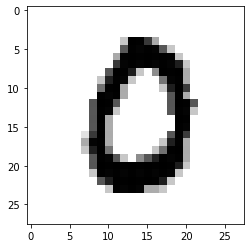

In [15]:
some_digit = X[35]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation = "nearest")
plt.show()

In [19]:
y[35]

0

In [18]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [17]:
#Classifer for just one number
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

#Use Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state = 0)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

array([False])

In [21]:
#Measuring Performance  - Cross Validation
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

KeyboardInterrupt: 

In [22]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([1.     , 0.72895, 1.     ])

In [23]:
#confusion matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)
confusion_matrix(y_train_5, y_train_pred)

array([[49523,  5056],
       [ 1034,  4387]])

In [58]:
#Precision & recall
from sklearn.metrics import precision_score, recall_score, f1_score

def display_precision_recall(train, pred):
    print("Precision:", precision_score(train, pred))
    print("Recall:", recall_score(train, pred))
    print("F1 score:", f1_score(train, pred))
          
display_precision_recall(y_train_5, y_train_pred)

Precision: 0.4645769352959864
Recall: 0.8092602840804279
F1 score: 0.5902852529601722


In [34]:
y_scores = sgd_clf.decision_function([some_digit])

In [25]:
y_scores

array([-3445.30483037])

In [35]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [36]:
#Deciding what threshold to use
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = "decision_function")

In [37]:
y_scores

array([ -4963.50067605,   3967.24287957, -10884.7238972 , ...,
       -10048.0318327 , -14518.99100052,  -4829.97328765])

In [39]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

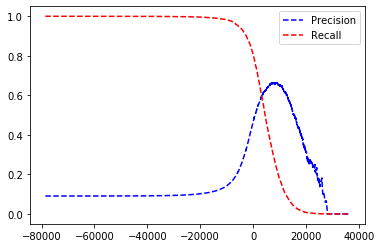

In [61]:
#plot precision and recall and threshold
def plot_prec_rec_thres(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label = 'Precision')
    plt.plot(thresholds, recalls[:-1], 'r--', label = 'Recall')
    plt.legend()

plot_prec_rec_thres(precisions, recalls, thresholds)
plt.show()

In [64]:
#Retrieve 50% precision using argmax
threshold_50_precision = thresholds[np.argmax(precisions >= 0.50)]
threshold_50_precision

795.7414095123959

In [68]:
y_train_pred_50 = (y_scores >= threshold_50_precision)
precision_score(y_train_5, y_train_pred_50)
recall_score(y_train_5, y_train_pred_50)

0.7609297177642501

In [71]:
y_scores

array([ -4963.50067605,   3967.24287957, -10884.7238972 , ...,
       -10048.0318327 , -14518.99100052,  -4829.97328765])

No handles with labels found to put in legend.


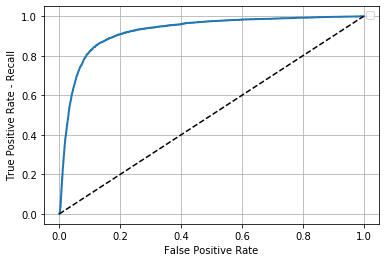

In [77]:
#ROC Curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate - Recall')
    plt.legend()
    plt.grid()

plot_roc_curve(fpr, tpr)
plt.show()
       

In [79]:
#calculate AUC - Area under the ROC score (<1)
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9246018928021691

In [81]:
#Implement Random Forest to test AUC and ROC
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state = 0)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, 
                                   method = "predict_proba")
y_probas_forest

array([[0.74, 0.26],
       [0.75, 0.25],
       [0.91, 0.09],
       ...,
       [0.94, 0.06],
       [0.84, 0.16],
       [0.93, 0.07]])

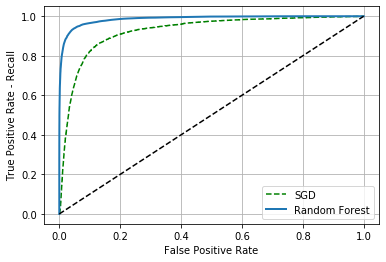

In [91]:
y_scores_forest = y_probas_forest[:,1] #score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

#Plot the ROC curve
plt.plot(fpr, tpr, 'g--', label = "SGD") #Plot SGD
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest") #Plot Random Forest
plt.legend()
plt.show()

In [95]:
#one vs. all stochastic gd
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([0], dtype=int8)

In [96]:
some_digit_scores = sgd_clf.decision_function([some_digit])
np.argmax(some_digit_scores)

0

In [97]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [ ]:
#Error Analysis
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv = 3)
conf_matrix = confusion_matrix(y_train, y_train_pred)
conf_matrix

In [ ]:
#97% Accuracy KNN
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
param_grid = [{'weights': ['uniform', 'distance'], 'n_neighbors': [3, 4, 5]}]
knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv = 2, verbose = 3)
grid_search.fit(X_train, y_train)